In [1]:
import torch
import torch.nn as nn
import torch_pruning as tp
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
from torchvision import transforms, datasets
import numpy as np
import torch.nn.utils.prune as prune
import pandas as pd

import matplotlib.pyplot as plt

from decimal import *

from PIL import Image
import math
import vgg
import os
import timeit
import operator
import copy
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
device = 'cuda'


N_CLASSES = 50

In [2]:
test_db_dir	 = '/media/revai/Data/Carlos/imagenet/50_classes/test/'
map_label_file = '/media/revai/Data/Carlos/imagenet/map_index_label_50_classes.txt'

map_index_to_label = {}
f = open(map_label_file)
f = f.readlines()

for i in range(len(f)):
	line = f[i]
	map_index_to_label[line.split('\n')[0]] = i

X_test = []
y_test = []

aux = []
		
for label in os.listdir(test_db_dir):
	count = 0    
	for img in os.listdir(test_db_dir + '/' + label):
		y_test.append(map_index_to_label[label])
		X_test.append(test_db_dir + '/' + label + '/' + img)
		if (count == 0): aux.append(test_db_dir + '/' + label + '/' + img)    
		count+=1

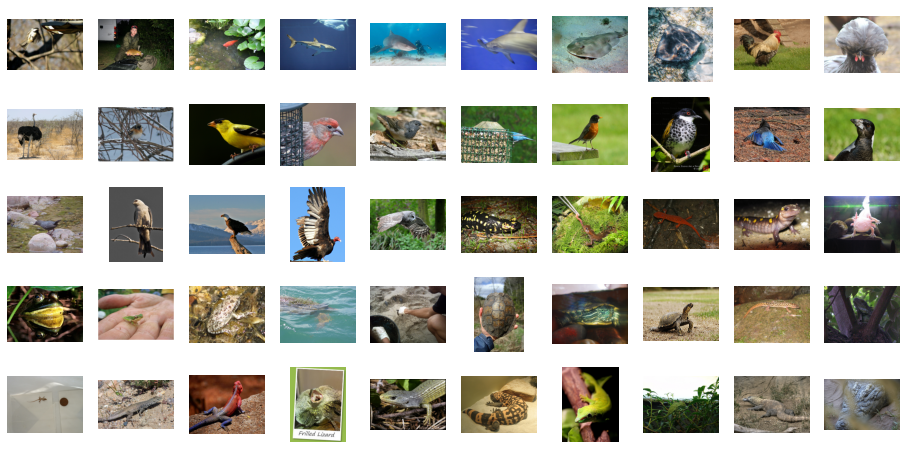

In [3]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
    img = plt.imread(aux[i-1])
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.axis('off')
plt.show()
fig.savefig('example_images_db.png', dpi=600)

In [4]:
preprocess = transforms.Compose([
	transforms.Resize(256),
	transforms.CenterCrop(224),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [39]:
df___ = pd.read_csv('results/time_result.csv')

In [40]:
df___

,Unnamed: 0,prune_technique,pruned_percent,round,filename,time_ms
0,0,ace,snapshots_0.1,1,/media/revai/Data/Carlos/imagenet/50_classes/t...,91.124296
1,1,ace,snapshots_0.1,1,/media/revai/Data/Carlos/imagenet/50_classes/t...,90.112448
2,2,ace,snapshots_0.1,1,/media/revai/Data/Carlos/imagenet/50_classes/t...,89.723110
3,3,ace,snapshots_0.1,1,/media/revai/Data/Carlos/imagenet/50_classes/t...,89.972019
4,4,ace,snapshots_0.1,1,/media/revai/Data/Carlos/imagenet/50_classes/t...,89.744568
...,...,...,...,...,...,...
1492,1492,ace,snapshots_0.3,1,/media/revai/Data/Carlos/imagenet/50_classes/t...,88.788033
1493,1493,ace,snapshots_0.3,1,/media/revai/Data/Carlos/imagenet/50_classes/t...,88.088751
1494,1494,ace,snapshots_0.3,1,/media/revai/Data/Carlos/imagenet/50_classes/t...,88.975430
1495,1495,ace,snapshots_0.3,1,/media/revai/Data/Carlos/imagenet/50_classes/t...,87.483883


In [5]:
def count_parameters(model):
	return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
import tqdm
def compute_acc_from_model_(model, X_val, y_val, top_n=1):
	l_relu_values = {}
	l_acc   = [0.0 for i in range(top_n)]
	
	acc = 0.0
	count = 0
	
	start = time.time()
	for i in range(len(X_val)):
		filename = X_val[i]
		exp_out = y_val[i]
		#exp_out = np.argmax(exp_out)

		input_image = Image.open(filename)
		#print ('{}/{}: {}'.format(i, len(X_val), filename))
		#input_torchvar = autograd.Variable(torch.FloatTensor(inp), requires_grad=True)
		try:
			input_tensor = preprocess(input_image)
		except:
			#print("An exception occurred")
			continue
		count+=1
		input_batch = torch.unsqueeze(input_tensor, 0) # create a mini-batch as expected by the model

		# move the input and model to GPU for speed if available
		if torch.cuda.is_available():
			input_batch = input_batch.to(device)
			model.to(device)
		model.eval()
		out_model = model.forward_hidden_test(input_batch, 200)

		out_softmax = torch.nn.functional.softmax(out_model[-1], dim=-1)
		out_softmax = out_softmax.reshape(N_CLASSES)
		out_aux = {}
		i = 0
		for key in out_softmax.cpu().detach().numpy():
			out_aux[i] = key
			i+=1
		out_aux = dict( sorted(out_aux.items(), key=operator.itemgetter(1),reverse=True))
		
		count_ = 0
		for key in out_aux:
			if (count_ >= top_n): break

			if (exp_out == key):
				for j in range(count_, top_n):
					l_acc[j]+=1
				acc += 1
				break
			count_ +=1
	for j in range(top_n):
		l_acc[j] /= count
	end = time.time()
	print('Time do compute accuracy: {}'.format(end-start))
	return (acc/count), l_acc

In [7]:
def measure_sparsity(module, weight=True, bias=False):
	num_zeros = 0
	num_elements = 0
	for param_name, param in module.named_parameters():
		print (param_name)
		if "weight" in param_name and weight == True:
			num_zeros += torch.sum(param == 0).item()
			num_elements += param.nelement()
		if "bias" in param_name and bias == True:
			num_zeros += torch.sum(param == 0).item()
			num_elements += param.nelement()
	print ('sparsity: {}'.format(float(num_zeros)/num_elements))
	return num_zeros


In [3]:
#df = pd.read_csv('/media/revai/Data/Carlos/ace_new_carlos_imp/res_finnetuning_freezed_conv_layers_best_result_finetuning.csv', delimiter=';')
#df_sem_finetuning = pd.read_csv('/media/revai/Data/Carlos/ace_new_carlos_imp/res_finnetuning_freezed_conv_layers_best_result_not_finetuning.csv', delimiter=';')
df = pd.read_csv('/media/revai/Data/Carlos/ace_new_carlos_imp/res_finnetuning_freezed_conv_layers_best_result_finetuning.csv', delimiter=';')

In [8]:
import random
random.seed(10081993)

l_percent_to_drop = [0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#l_approach = ['ace', 'l1_unstructured', 'ln_structured', 'random', 'random_structured', 'random_unstructured']
l_approach = ['ace', 'l1_unstructured', 'random']
l_approach = ['original']
l_percent_to_drop = ['original']
filename_model = 'best_model.pth'

snapshot_dir = '/media/revai/Data/Carlos/ace_new_carlos_imp/results/exp_finnetuning_freezed_layers/'
model_original_filepath = '/media/revai/Data/Carlos/ace_new_carlos_imp/snapshots_50_sgd_freezed_conv_layers/model_weights_epoch_92.pth'
#df_out = pd.DataFrame({})
df_out = pd.read_csv('res_bootstrapping_finetuning.csv')

f_out = open('res_bootstrapping_finetuning_original_model.txt', 'w')

for prune_percent in l_percent_to_drop:
    d_models = {}
    d_models['original'] = torch.load(model_original_filepath)
    #for approach in l_approach:
    #    d_models[approach] = torch.load(f'{snapshot_dir}/{approach}/snapshots_{prune_percent}/{filename_model}')
    
    for n_exp in range(30):
        random_index_list = random.sample(range(0, 50), 30)
        x_random_test = []
        y_random_test = []
        for i in range(0, len(y_test), 50):
            y_test_by_class = y_test[i:i+50]
            x_test_by_class = X_test[i:i+50]
            
            x_random_test_by_class = [x_test_by_class[index] for index in random_index_list]
            y_random_test_by_class = [y_test_by_class[index] for index in random_index_list]
            
            x_random_test.extend(x_random_test_by_class)
            y_random_test.extend(y_random_test_by_class)
        
        print (f'computing acc for exp {n_exp + 1}')
        for approach in l_approach:            
            acc, l_acc = compute_acc_from_model_(d_models[approach], x_random_test, y_random_test, top_n=5)
            d = {'prune_percent': prune_percent,
                'approach': approach,
                'top1':l_acc[0], 'top2':l_acc[1], 'top3':l_acc[2], 'top4':l_acc[3], 'top5':l_acc[4]}
            df_out = df_out.append(d, ignore_index=True)

            sss = str(l_acc).replace('[', '').replace(']', '').replace(',',';').replace(' ', '')
            f_out.write(f'{approach};{prune_percent};{filename_model};{sss};\n')
        
    df_out.to_csv('res_bootstrapping_finetuning_original_model.txt.csv')
df_out.to_csv('res_bootstrapping_finetuning_original_model.txt.csv')
f_out.close()

computing acc for exp 1
Time do compute accuracy: 29.57293939590454
computing acc for exp 2
Time do compute accuracy: 17.898010730743408
computing acc for exp 3
Time do compute accuracy: 13.669945240020752
computing acc for exp 4
Time do compute accuracy: 15.447343587875366
computing acc for exp 5
Time do compute accuracy: 13.73229718208313
computing acc for exp 6
Time do compute accuracy: 13.484986782073975
computing acc for exp 7
Time do compute accuracy: 13.009945392608643
computing acc for exp 8
Time do compute accuracy: 13.407342195510864
computing acc for exp 9
Time do compute accuracy: 13.30614423751831
computing acc for exp 10
Time do compute accuracy: 13.158761739730835
computing acc for exp 11
Time do compute accuracy: 13.010403871536255
computing acc for exp 12
Time do compute accuracy: 13.16565990447998
computing acc for exp 13
Time do compute accuracy: 13.056622743606567
computing acc for exp 14
Time do compute accuracy: 12.849908828735352
computing acc for exp 15
Time do 

In [4]:
df_out = pd.read_csv('res_bootstrapping_finetuning.csv')

In [9]:
df_out.head()

,Unnamed: 0,prune_percent,approach,top1,top2,top3,top4,top5
0,0,0.95,ace,0.513387,0.667336,0.740964,0.785810,0.819946
1,1,0.95,l1_unstructured,0.520080,0.670013,0.733601,0.779786,0.806560
2,2,0.95,ln_structured,0.510040,0.647256,0.709505,0.744980,0.791165
3,3,0.95,random,0.515395,0.670013,0.729585,0.779116,0.813922
4,4,0.95,random_structured,0.491299,0.643240,0.716198,0.764391,0.789157


In [ ]:
import random
random.seed(10081993)

l_percent_to_drop = [0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
l_approach = ['ace', 'l1_unstructured', 'ln_structured', 'random', 'random_structured', 'random_unstructured']
filename_model = 'best_model.pth'

snapshot_dir = '/media/revai/Data/Carlos/ace_new_carlos_imp/results/exp_finnetuning_freezed_layers/'
df_out = pd.DataFrame({})

f_out = open('random_test_result_without_finnetuning.txt', 'w')

for prune_percent in l_percent_to_drop:
    d_models = {}
    for approach in l_approach:
        d_models[approach] = torch.load(f'{snapshot_dir}/{approach}/snapshots_{prune_percent}/{filename_model}')
    

for index, row in df.iterrows():
    approach = row['approach']
    if (approach != 'ace'):continue 
    prune_percent = row['prune_percent']
    filename_ace_model = row['filename_model']
    filename_ln_structured_model = df[(df['approach'] == 'ln_structured') & (df['prune_percent'] == prune_percent)]['filename_model'].values[0]
    filename_random_model = df[(df['approach'] == 'random') & (df['prune_percent'] == prune_percent)]['filename_model'].values[0]

    model_ace = torch.load(f'{snapshot_dir}/{approach}/snapshots_{prune_percent}/{filename_ace_model}')
    model_ln_structured = torch.load(f'{snapshot_dir}/ln_structured/snapshots_{prune_percent}/{filename_ln_structured_model}')
    model_random = torch.load(f'{snapshot_dir}/random/snapshots_{prune_percent}/{filename_random_model}')
    
    for n_exp in range(30):
        random_index_list = random.sample(range(0, 50), 30)
        x_random_test = []
        y_random_test = []
        for i in range(0, len(y_test), 50):
            y_test_by_class = y_test[i:i+50]
            x_test_by_class = X_test[i:i+50]
            
            x_random_test_by_class = [x_test_by_class[index] for index in random_index_list]
            y_random_test_by_class = [y_test_by_class[index] for index in random_index_list]
            
            x_random_test.extend(x_random_test_by_class)
            y_random_test.extend(y_random_test_by_class)
        
        print (f'computing acc for exp {n_exp + 1}')
        acc, l_acc = compute_acc_from_model_(model_ace, x_random_test, y_random_test, top_n=5)
        d = {'prune_percent': prune_percent,
            'approach': approach,
            'top1':l_acc[0], 'top2':l_acc[1], 'top3':l_acc[2], 'top4':l_acc[3], 'top5':l_acc[4]}
        df_out = df_out.append(d, ignore_index=True)
        sss = str(l_acc).replace('[', '').replace(']', '').replace(',',';').replace(' ', '')
        f_out.write(f'{approach};{prune_percent};{filename_ace_model};{sss};\n')
        
        acc, l_acc = compute_acc_from_model_(model_ln_structured, x_random_test, y_random_test, top_n=5)
        d = {'prune_percent': prune_percent,
            'approach': 'ln_structured',
            'top1':l_acc[0], 'top2':l_acc[1], 'top3':l_acc[2], 'top4':l_acc[3], 'top5':l_acc[4]}
        df_out = df_out.append(d, ignore_index=True)
        sss = str(l_acc).replace('[', '').replace(']', '').replace(',',';').replace(' ', '')
        f_out.write(f'ln_structured;{prune_percent};{filename_ln_structured_model};{sss};\n')

        acc, l_acc = compute_acc_from_model_(model_random, x_random_test, y_random_test, top_n=5)
        d = {'prune_percent': prune_percent,
            'approach': 'random',
            'top1':l_acc[0], 'top2':l_acc[1], 'top3':l_acc[2], 'top4':l_acc[3], 'top5':l_acc[4]}
        df_out = df_out.append(d, ignore_index=True)
        sss = str(l_acc).replace('[', '').replace(']', '').replace(',',';').replace(' ', '')
        f_out.write(f'random;{prune_percent};{filename_ln_structured_model};{sss};\n')

        
    df_out.to_csv('res_bootstrapping_ace_ln_random_finetuning.csv')
df_out.to_csv('res_bootstrapping_ace_ln_random_finetuning.csv')
f_out.close()
    
    

In [ ]:
snapshot_dir = '/media/revai/Data/Carlos/ace_new_carlos_imp/results/exp_finnetuning_freezed_layers/'
df_out = pd.DataFrame({})

f_out = open('random_test_result_without_finnetuning.txt', 'w')
for index, row in df_sem_finetuning.iterrows():
    approach = row['approach']
    if (approach != 'ace'):continue 
    prune_percent = row['prune_percent']
    filename_ace_model = row['filename_model']
    filename_ln_structured_model = df_sem_finetuning[(df_sem_finetuning['approach'] == 'ln_structured') & (df_sem_finetuning['prune_percent'] == prune_percent)]['filename_model'].values[0]
    filename_random_model = df_sem_finetuning[(df_sem_finetuning['approach'] == 'random') & (df_sem_finetuning['prune_percent'] == prune_percent)]['filename_model'].values[0]

    model_ace = torch.load(f'{snapshot_dir}/{approach}/snapshots_{prune_percent}/{filename_ace_model}')
    model_ln_structured = torch.load(f'{snapshot_dir}/ln_structured/snapshots_{prune_percent}/{filename_ln_structured_model}')
    model_random = torch.load(f'{snapshot_dir}/random/snapshots_{prune_percent}/{filename_random_model}')
    
    for n_exp in range(30):
        random_index_list = random.sample(range(0, 50), 30)
        x_random_test = []
        y_random_test = []
        for i in range(0, len(y_test), 50):
            y_test_by_class = y_test[i:i+50]
            x_test_by_class = X_test[i:i+50]
            
            x_random_test_by_class = [x_test_by_class[index] for index in random_index_list]
            y_random_test_by_class = [y_test_by_class[index] for index in random_index_list]
            
            x_random_test.extend(x_random_test_by_class)
            y_random_test.extend(y_random_test_by_class)
        
        print (f'computing acc for exp {n_exp + 1}')
        acc, l_acc = compute_acc_from_model_(model_ace, x_random_test, y_random_test, top_n=5)
        d = {'prune_percent': prune_percent,
            'approach': approach,
            'top1':l_acc[0], 'top2':l_acc[1], 'top3':l_acc[2], 'top4':l_acc[3], 'top5':l_acc[4]}
        df_out = df_out.append(d, ignore_index=True)
        sss = str(l_acc).replace('[', '').replace(']', '').replace(',',';').replace(' ', '')
        f_out.write(f'{approach};{prune_percent};{filename_ace_model};{sss};\n')
        
        acc, l_acc = compute_acc_from_model_(model_ln_structured, x_random_test, y_random_test, top_n=5)
        d = {'prune_percent': prune_percent,
            'approach': 'ln_structured',
            'top1':l_acc[0], 'top2':l_acc[1], 'top3':l_acc[2], 'top4':l_acc[3], 'top5':l_acc[4]}
        df_out = df_out.append(d, ignore_index=True)
        sss = str(l_acc).replace('[', '').replace(']', '').replace(',',';').replace(' ', '')
        f_out.write(f'ln_structured;{prune_percent};{filename_ln_structured_model};{sss};\n')

        acc, l_acc = compute_acc_from_model_(model_random, x_random_test, y_random_test, top_n=5)
        d = {'prune_percent': prune_percent,
            'approach': 'random',
            'top1':l_acc[0], 'top2':l_acc[1], 'top3':l_acc[2], 'top4':l_acc[3], 'top5':l_acc[4]}
        df_out = df_out.append(d, ignore_index=True)
        sss = str(l_acc).replace('[', '').replace(']', '').replace(',',';').replace(' ', '')
        f_out.write(f'random;{prune_percent};{filename_ln_structured_model};{sss};\n')

        
    df_out.to_csv('res_bootstrapping_ace_ln_random_sem_finetuning.csv')
df_out.to_csv('res_bootstrapping_ace_ln_random_sem_finetuning.csv')
f_out.close()

In [ ]:
df_out

In [ ]:
df_mean = df_out.groupby(['prune_percent', 'approach'])[['top5']].mean().reset_index()
df_mean.to_csv('random_test_result_mean_df_.csv')

In [ ]:
df_std = df_out.groupby(['prune_percent', 'approach'])[['top5']].std().reset_index()
df_std.to_csv('random_test_result_std_df_.csv')

In [42]:
#l_approach = ['ace', 'l1_unstructured', 'ln_structured', 'random', 'random_structured', 'random_unstructured']
l_approach = ['ace', 'ln_structured', 'random']

df_com_finetuning = pd.read_csv('res_bootstrapping_finetuning_original_model.txt.csv')
#df_sem_finetuning = pd.read_csv('random_test_result_df_without_finnetuning.csv')

In [7]:
l_percent_to_drop = [0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

l_approach = ['ace', 'ln_structured', 'random']
filename_model = 'best_model.pth'

snapshot_dir = '/media/revai/Data/Carlos/ace_new_carlos_imp/results/exp_finnetuning_freezed_layers/'

for approach in l_approach:
    for prune_percent in l_percent_to_drop:
        model = torch.load(f'{snapshot_dir}/{approach}/snapshots_{prune_percent}/{filename_model}')
        print (f'{prune_percent} - {approach}: {count_parameters(model)}')

0.95 - ace: 5195775
0.9 - ace: 10475550
0.8 - ace: 21287250
0.7 - ace: 32407551
0.6 - ace: 43890831
0.5 - ace: 55681074
0.4 - ace: 67835934
0.3 - ace: 80326994
0.2 - ace: 93122559
0.1 - ace: 106285199
0.95 - ln_structured: 119750706
0.9 - ln_structured: 119750706
0.8 - ln_structured: 119750706
0.7 - ln_structured: 119750706
0.6 - ln_structured: 119750706
0.5 - ln_structured: 119750706
0.4 - ln_structured: 119750706
0.3 - ln_structured: 119750706
0.2 - ln_structured: 119750706
0.1 - ln_structured: 119750706
0.95 - random: 5195775
0.9 - random: 10475550
0.8 - random: 21287250
0.7 - random: 32407551
0.6 - random: 43890831
0.5 - random: 55681074
0.4 - random: 67835934
0.3 - random: 80326994
0.2 - random: 93122559
0.1 - random: 106285199


In [10]:
#glob.glob(f'{snapshot_dir}/original_model/**/best_model.pth', recursive=True)
model = torch.load(f'{snapshot_dir}/original_model/original/{filename_model}')
print (f'{count_parameters(model)}')


119750706


In [2]:
df_com_finetuning = pd.read_csv('res_bootstrapping_finetuning_original_model.txt.csv')

original_data = df_com_finetuning[df_com_finetuning['approach'] == 'original']

df_com_finetuning.prune_percent = df_com_finetuning.prune_percent.apply(lambda x: x if x!='original' else 0.95)

l_percent_to_drop = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
for p in l_percent_to_drop:
    original_data['prune_percent'] = p
    df_com_finetuning = df_com_finetuning.append(original_data, ignore_index=True)

df_com_finetuning['prune_percent'] = df_com_finetuning['prune_percent'].astype(float)
    

In [64]:
df_com_finetuning[df_com_finetuning['approach'] == 'original'].prune_percent.value_counts()

0.95    30
0.90    30
0.80    30
0.70    30
0.60    30
0.50    30
0.40    30
0.30    30
0.20    30
0.10    30
Name: prune_percent, dtype: int64

In [7]:

data_original = df_com_finetuning[df_com_finetuning['approach'] == 'original']
df_approach_original   = data_original.groupby(['prune_percent']).apply(get_confidence_interval).reset_index()

In [13]:
ori_mean = 81.939289
ori_ci = 0.179171

intervalo_ori = [ori_mean - ori_ci, ori_mean + ori_ci]

In [14]:
df_approach

,prune_percent,mean,ci_lower,ci_upper
0,0.10,81.939289,0.179171,0.179171
1,0.20,81.939289,0.179171,0.179171
2,0.30,81.939289,0.179171,0.179171
3,0.40,81.939289,0.179171,0.179171
4,0.50,81.939289,0.179171,0.179171
5,0.60,81.939289,0.179171,0.179171
6,0.70,81.939289,0.179171,0.179171
7,0.80,81.939289,0.179171,0.179171
8,0.90,81.939289,0.179171,0.179171
9,0.95,81.939289,0.179171,0.179171


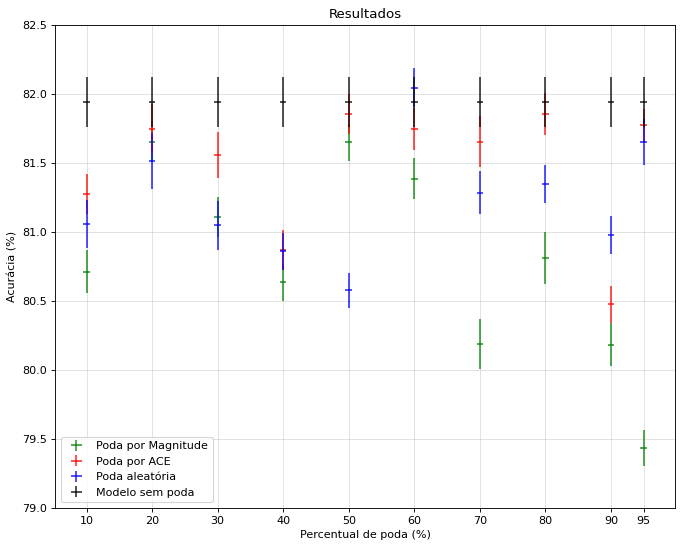

In [15]:
import numpy as np
import scipy.stats as st

def intersecta(intervalo1, intervalo2):
    return (intervalo1[0] > intervalo2[1] or intervalo2[0] > intervalo1[1]) == False

plt.figure(figsize=(10, 8), dpi=80)

#['ace', 'l1_unstructured', 'ln_structured', 'random', 'random_structured', 'random_unstructured']

d_colors = {'ace':'red', 'ln_structured':'green', 'original':'black', 'random':'blue', 'random_structured':'purple', 'random_unstructured':'slategray'}

def get_confidence_interval(g):
    #normal
    ci = st.norm.interval(alpha=0.99, loc=np.mean(g['top5']), scale=st.sem(g['top5']))
    #t-student
    #ci = st.t.interval(alpha=0.99, df=len(g)-1, loc=np.mean(g['top5']), scale=st.sem(g['top5']))
    mean = np.mean(g['top5']) * 100

    return pd.Series({'mean':mean, 'ci_lower': mean-(ci[0]*100), 'ci_upper': (ci[1]*100)-mean})

l_approach = ['ln_structured', 'ace', 'random', 'original']
#l_approach = ['original']
d_filename_sufix = {'ln_structured_': '_magnitude', 
                 'ace_': '_ace',
                 'random_': '_aleatorio', 
                 'original_': '_original',
                 'ln_structured_ace_random_': '',
                 'ln_structured_ace_random_original_': ''}
filename_sufix = ''
df_gain = pd.DataFrame({})
for approach in l_approach:
    data = df_com_finetuning[df_com_finetuning['approach'] == approach]
    df_approach   = data.groupby(['prune_percent']).apply(get_confidence_interval).reset_index()

    yerr=[np.array(df_approach['ci_lower']), np.array(df_approach['ci_upper'])]
    
    for index, row in df_approach.iterrows():
        intervalo = [row['mean'] - row['ci_lower'], row['mean'] + row['ci_upper']]
        gain = 0
        if (intersecta(intervalo, intervalo_ori) == False):
            gain = intervalo[1] - intervalo_ori[0]
        new_row = {'approach': approach,  'prune_percent': row['prune_percent'], 'gain': gain}
        df_gain = df_gain.append(new_row, ignore_index=True)
        
    
    label = approach
    if (approach == 'ace'):
        label = 'Poda por ACE'
    if (approach == 'ln_structured'):
        label = 'Poda por Magnitude'
    if (approach == 'random'):
        label = 'Poda aleatória'
    if (approach == 'original'):
        label = 'Modelo sem poda'
    filename_sufix += (approach + '_') 
    #print (f'{approach}: {yerr}')
    #print (df_approach['mean'])
    #print ('=====')
    plt.errorbar(df_approach['prune_percent']*100, df_approach['mean'], xerr=.5, yerr=yerr,
                linestyle='', c=d_colors[approach], alpha=0.8, label=label)

x = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95]
default_x_ticks = range(len(x))
    
plt.xlabel('Percentual de poda (%)')
plt.ylabel('Acurácia (%)')
plt.title('Resultados')
plt.ylim(79, 82.5)
plt.xticks(x)
plt.grid(alpha=0.4)
plt.legend(loc='lower left')

plt.savefig(f'resultado_acuracia{d_filename_sufix[filename_sufix]}.png', dpi=400)

In [16]:
df_gain

,approach,prune_percent,gain
0,ln_structured,0.10,-0.895706
1,ln_structured,0.20,0.000000
2,ln_structured,0.30,-0.505466
3,ln_structured,0.40,-0.991163
4,ln_structured,0.50,0.000000
5,ln_structured,0.60,-0.229378
6,ln_structured,0.70,-1.396169
7,ln_structured,0.80,-0.763047
8,ln_structured,0.90,-1.424016
9,ln_structured,0.95,-2.197061


In [ ]:
import numpy as np
import scipy.stats as st

plt.figure(figsize=(10, 8), dpi=80)

#['ace', 'l1_unstructured', 'ln_structured', 'random', 'random_structured', 'random_unstructured']
d_colors = {'ace':'red', 'l1_unstructured':'sienna', 'ln_structured':'green', 'random':'blue', 'random_structured':'purple', 'random_unstructured':'stategray'}

def get_confidence_interval(g):
    #normal
    ci = st.norm.interval(alpha=0.99, loc=np.mean(g['top5']), scale=st.sem(g['top5']))
    #t-student
    #ci = st.t.interval(alpha=0.99, df=len(g)-1, loc=np.mean(g['top5']), scale=st.sem(g['top5']))
    mean = np.mean(g['top5']) * 100

    return pd.Series({'mean':mean, 'ci_lower': mean-(ci[0]*100), 'ci_upper': (ci[1]*100)-mean})


for approach in l_approach:
    data = df_com_finetuning[df_com_finetuning['approach'] == approach]
    df_approach   = data.groupby(['prune_percent']).apply(get_confidence_interval).reset_index()

    yerr=[np.array(df_approach['ci_lower']), np.array(df_approach['ci_upper'])]

    plt.errorbar(df_approach['prune_percent']*100, df_approach['mean'], xerr=1, yerr=yerr,
                linestyle='', c=d_colors[approach], alpha=0.8, label=approach)


ace_data = df_com_finetuning[df_com_finetuning['approach'] == 'ace']
df_ace   = ace_data.groupby(['prune_percent']).apply(get_confidence_interval).reset_index()

ln_structured_data = df_com_finetuning[df_com_finetuning['approach'] == 'ln_structured']
df_ln_structured   = ln_structured_data.groupby(['prune_percent']).apply(get_confidence_interval).reset_index()

random_data = df_com_finetuning[df_com_finetuning['approach'] == 'random']
df_random   = random_data.groupby(['prune_percent']).apply(get_confidence_interval).reset_index()

yerr_ace=[np.array(df_ace['ci_lower']), np.array(df_ace['ci_upper'])]
yerr_ln_structured=[np.array(df_ln_structured['ci_lower']), np.array(df_ln_structured['ci_upper'])]
yerr_random=[np.array(df_random['ci_lower']), np.array(df_random['ci_upper'])]

plt.errorbar(df_ace['prune_percent']*100, df_ace['mean'], xerr=1, yerr=yerr_ace,
                linestyle='', c='red', alpha=0.8, label='ace')

plt.errorbar(df_ln_structured['prune_percent']*100, df_ln_structured['mean'], xerr=1, yerr=yerr_ln_structured,
                linestyle='', c='blue', alpha=0.8, label='ln_structured')

plt.errorbar(df_random['prune_percent']*100, df_random['mean'], xerr=1, yerr=yerr_random,
                linestyle='', c='green', alpha=0.8, label='random')

plt.xlabel('Percentual de poda')
plt.ylabel('Acurácia')
plt.title('Com Finetuning')
plt.legend(loc='lower left')

In [ ]:
#Sem FINETUNING
plt.figure(figsize=(10, 8), dpi=80)
ace_data = df_sem_finetuning[df_sem_finetuning['approach'] == 'ace']
df_ace   = ace_data.groupby(['prune_percent']).apply(get_confidence_interval).reset_index()

ln_structured_data = df_sem_finetuning[df_sem_finetuning['approach'] != 'ace']
df_ln_structured   = ln_structured_data.groupby(['prune_percent']).apply(get_confidence_interval).reset_index()

random_data = df_com_finetuning[df_com_finetuning['approach'] == 'random']
df_random   = random_data.groupby(['prune_percent']).apply(get_confidence_interval).reset_index()

yerr_ace=[np.array(df_ace['ci_lower']), np.array(df_ace['ci_upper'])]
yerr_ln_structured=[np.array(df_ln_structured['ci_lower']), np.array(df_ln_structured['ci_upper'])]
yerr_random=[np.array(df_random['ci_lower']), np.array(df_random['ci_upper'])]

plt.errorbar(df_ace['prune_percent']*100, df_ace['mean'], xerr=1, yerr=yerr_ace,
                linestyle='', c='red', alpha=0.8, label='ace')

plt.errorbar(df_ln_structured['prune_percent']*100, df_ln_structured['mean'], xerr=1, yerr=yerr_ln_structured,
                linestyle='', c='blue', alpha=0.8, label='ln_structured')

# plt.errorbar(df_random['prune_percent']*100, df_random['mean'], xerr=1, yerr=yerr_random,
#                 linestyle='', c='green', alpha=0.8, label='random')

plt.xlabel('Percentual de poda')
plt.ylabel('Acurácia')
plt.title('Sem Finetuning')
plt.legend(loc='lower left')

In [ ]:
df_ace.dtypes

In [ ]:

plt.figure(figsize=(12, 10), dpi=80)

mean = df_mean[df_mean['approach'] == 'ace']
std = df_std[df_std['approach'] == 'ace']

mean_ln = df_mean[df_mean['approach'] != 'ace']
std_ln = df_std[df_std['approach'] != 'ace']

plt.errorbar(mean['prune_percent']*100, mean['top5'], xerr=1.5, yerr=2*std['top5'],
               linestyle='', c='red', alpha=0.7, label='ace')


plt.errorbar(mean_ln['prune_percent']*100, mean_ln['top5'], xerr=1.5, yerr=2*std_ln['top5'],
               linestyle='', c='blue', alpha=0.7, label='ln_structured')

plt.legend(loc='lower left')
plt.show()

In [ ]:
!pip install -U scikit-learn

In [ ]:
snapshot_dir = '/media/revai/Data/Carlos/ace_new_carlos_imp/results/exp_finnetuning_freezed_layers/'

for index, row in df.iterrows():
    approach = row['approach']
    prune_percent = row['prune_percent']
    filename_model = row['filename_model']
    model = torch.load(f'{snapshot_dir}/{approach}/snapshots_{prune_percent}/{filename_model}')
    n_params = count_parameters(model)
    print (f'{approach} ({prune_percent}) - {filename_model}: {n_params}')
    